In [38]:
import os
import pandas as pd
import geopandas as gpd
import requests
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import geopandas as gpd
from shapely.geometry import Point
import uuid


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
os.chdir("/content/drive/MyDrive/CHVI")


# Shapefile

In [40]:
# Import shapefile
blocks_shp=gpd.read_file("5_Shapefiles/blocks.geojson")

<Axes: >

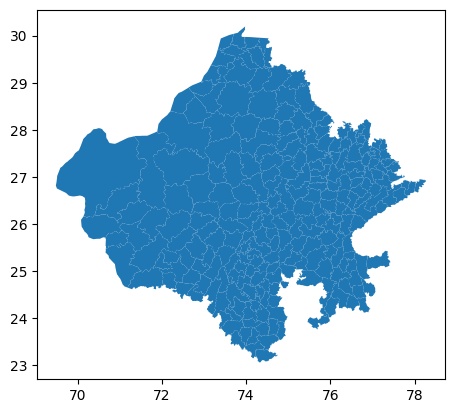

In [41]:
blocks_shp.plot()

In [20]:
blocks_shp.columns

Index(['NAME', 'DISTRICT', 'C_CODE11', 'geometry'], dtype='object')

In [21]:
len(blocks_shp)

244

In [25]:
blocks_shp.du(by=["DISTRICT", "NAME"]).nunique()

C_CODE11  geometry
DISTRICT NAME                          
Ajmer    Ajmer              1         1
         Beawar             1         1
         Bhinay             1         1
         Kekri              1         1
         Kishangarh         1         1
...                       ...       ...
Udaipur  Lasadia            1         1
         Mavli              1         1
         Rishabdev          1         1
         Salumbar           1         1
         Sarada             1         1

[242 rows x 2 columns]

In [31]:
unique_subdistricts = blocks_shp[['DISTRICT', 'NAME']].drop_duplicates()
print(f"{len(unique_subdistricts)} unique subdistricts. {len(blocks_shp)-len(unique_subdistricts)} duplicates")

242 unique subdistricts. 2 duplicates


In [36]:
duplicate_blocks=blocks_shp[blocks_shp.duplicated(subset=["DISTRICT", "NAME"], keep=False)].sort_values(by=["DISTRICT", "NAME"])

<Axes: >

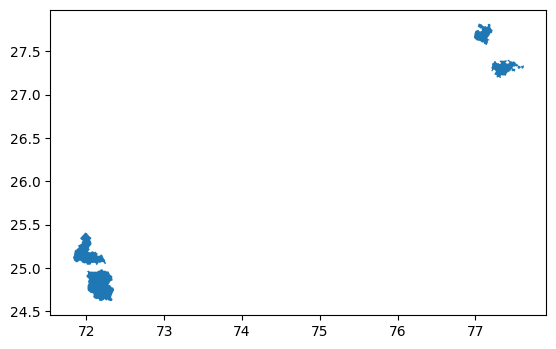

In [37]:
duplicate_blocks.plot()

In [5]:
blocks_shp["NAME"].nunique()

238

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    elif month in [9, 10, 11]:
        return 'Post-Monsoon'
    else:
        return 'Winter'

# Dengue 2024

## Dengue - 1st Jan 2024 - 28th Nov 2024
- Out of 34,441 villages in Rajasthan, only 2,878 villages (8.36%) reported any cases of Dengue.

- 9 sub-districts did not report any cases:
('Dungarpur', 'Simalwara')
('Dungarpur', 'Sagwara')
('Dungarpur', 'Aspur')
('Sirohi', 'Reodar')
('Jalor', 'Raniwara')
('Pali', 'Sumerpur')
('Pali', 'Marwar Junction')
('Pali', 'Rohat')
('Sawai Madhopur', '91 (Unknown Sub-district')
('Jodhpur', 'Phalodi')
- All 34 districts reported at least 1 case


## Malaria - 1st Jan 2024 - 30th Nov 2024
- Out of 34,441 villages in Rajasthan, only 740 villages (2.15%) reported any cases of Malaria.

- 101 sub-districts did not report any cases

- 4 districts - Jhalawar, Baran, Karauli, Dhaulpur did not report any cases in the 11 month period


In [ ]:
# # dengue with patient lat-long
dengue = gpd.read_file("dengue_malaria/clean/dengue_patient_locations.gpkg", layer='patients')

In [ ]:
# Fix date - should be 2024
dengue["sample_date"] = pd.to_datetime(dengue["sample_date"])

# Replace year < 2024 with 2024
dengue.loc[dengue["sample_date"].dt.year < 2024, "sample_date"] = dengue.loc[dengue["sample_date"].dt.year < 2024, "sample_date"].apply(lambda x: x.replace(year=2024))

In [ ]:
# Map dengue cases to blocks
dengue_blocks=gpd.sjoin(dengue, blocks_shp, how="left", predicate="within")

In [ ]:
dengue_blocks.loc[dengue_blocks["sdtname"].isna(), "sdtname"] = dengue_blocks.loc[dengue_blocks["sdtname"].isna(), "SUB_DIST"]
dengue_blocks.loc[dengue_blocks["dtname"].isna(), "dtname"] = dengue_blocks.loc[dengue_blocks["dtname"].isna(), "DISTRICT"]

In [ ]:
# Aggregate dengue cases at the block-level
dengue_blocks_agg = (
    dengue_blocks.groupby(by=["dtname", "sdtname", "sample_date"])
    .size()
    .reset_index()
    .rename(columns={0: "dengue_cases"})
)

In [ ]:
dengue_blocks_agg["dengue_cases"].sum()

np.int64(9385)

In [ ]:
dengue_blocks_agg.isna().sum()

,0
dtname,0
sdtname,0
sample_date,0
dengue_cases,0


# Dengue 2025 - Dec 2024 - June 2025
- Link to data: [here](https://docs.google.com/spreadsheets/d/1lo7Z4jzo_bLVxBtHD40AzGH514Tv1WfdEGE8wHx-BjM/edit?gid=1495055077#gid=1495055077)
- Balotra & Phalodi subdistricts have not reported any cases in 2025
- 624 cases of which 9 were dropped due to invalid location/date.
- Mapping based on lat-long > patient block name (fuzzy match) > HF block (fuzzy match)



In [ ]:
wb=pd.ExcelFile("dengue_malaria/raw/Dengue AXN Taken 2025 Automation Sheet.xlsx")

In [ ]:
import re
import datetime

def string_clean_dates(*, Date) -> datetime.datetime:
    """Nullifies dates with no number, cleans extraneous elements in dates, and converts to datetime format

    Args:
        Date (str or datetime or NaT): date in dataset

    Returns:
        datetime: date in datetime format
    """

    if not re.search(r"[0-9]", str(Date)):
        return pd.NaT

    Date = re.sub(r"\-\-", "-", str(Date))

    formats = ["%d/%m/%y", "%m/%d/%y", "%d/%m/%Y", "%m/%d/%Y"]

    # parse with multiple formats
    for fmt in formats:
        try:
            parsed_date = pd.to_datetime(str(Date), format=fmt)
            return parsed_date
        except ValueError:
            continue

    # If formats above don't work, try parsing with mixed formats - if value error, nullify
    try:
        return pd.to_datetime(Date, format="mixed")
    except ValueError:
        return pd.NaT

In [ ]:
# Main processing loop
skipped = []
main_df = pd.DataFrame()

for sheet in wb.sheet_names:
    if sheet in ["Form Responses 1", "remaining data", "Pending Dengue Cases in Linelis"]:
        continue

    try:
        data = pd.read_excel(wb, sheet, skiprows=2)
    except Exception as e:
        print(f"Sheet: {sheet}. Error reading: {e}. Skipped.")
        skipped.append(sheet)
        continue

    if "S.No" not in data.columns:
        print(f"Sheet: {sheet}. Columns not aligned. Skipped.")
        skipped.append(sheet)
        continue

    if len(data) < 1:
        print(f"Sheet: {sheet}. No data found. Skipped.")
        skipped.append(sheet)
        continue

    data = data.rename(columns={
        "District (Patient)": "District(Patient)",
        "Sub District (Patient)": "Sub District(Patient)"
    })

    data = data.dropna(subset=["Patient Name"])

    try:
        data_filtered = data.dropna(
            subset=["Sub District(Patient)", "Lat-Long", "H F Block", "Sample Collected Date", "Test Performed Date"],
            how="all"
        )
        if len(data) - len(data_filtered) > 0:
            print(f"{sheet}: {len(data) - len(data_filtered)} rows dropped")
        data_filtered = data_filtered[[
            "District(Patient)", "Sub District(Patient)", "Lat-Long",
            "Sample Collected Date", "Test Performed Date", "H F Block", 'Action Taken Date', 'Urban/\n Rural', 'Total House Visit','Total House Positive', 'Total container check',
            'Total container Positive', 'No of Total Source Reducted Container','BTI', 'House', 'Room','No of fooging Activity Sites', 'Post']]
    except KeyError as e:
        print(f"Sheet: {sheet}. Missing columns: {e}. Skipped.")
        skipped.append(sheet)
        continue

    if len(data_filtered) > 0:

        main_df = pd.concat([main_df, data_filtered], ignore_index=True)
    else:
        print(f"Sheet: {sheet}. No valid rows after filtering. Skipped.")
        skipped.append(sheet)


Sheet: Balotra. Missing columns: ['Lat-Long']. Skipped.


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell AD14 is marked as a date but the serial value 6715097.0 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)


Sheet: Phalodi. No valid rows after filtering. Skipped.


In [ ]:
len(main_df)

624

In [ ]:
main_df.columns

Index(['District(Patient)', 'Sub District(Patient)', 'Lat-Long',
       'Sample Collected Date', 'Test Performed Date', 'H F Block',
       'Action Taken Date', 'Urban/\n Rural', 'Total House Visit',
       'Total House Positive', 'Total container check',
       'Total container Positive', 'No of Total Source Reducted Container',
       'BTI', 'House', 'Room', 'No of fooging Activity Sites', 'Post'],
      dtype='object')

In [ ]:
main_df['Sample Collected Date']=main_df['Sample Collected Date'].apply(lambda x: string_clean_dates(Date=x))

In [ ]:
main_df['Test Performed Date']=main_df['Test Performed Date'].apply(lambda x: string_clean_dates(Date=x))

In [ ]:
main_df["Action Taken Date"]=main_df["Action Taken Date"].apply(lambda x: string_clean_dates(Date=x))

In [ ]:
main_df[main_df["Sample Collected Date"]>pd.to_datetime("2025-08-28")]

,District(Patient),Sub District(Patient),Lat-Long,Sample Collected Date,Test Performed Date,H F Block,Action Taken Date,Urban/\n Rural,Total House Visit,Total House Positive,Total container check,Total container Positive,No of Total Source Reducted Container,BTI,House,Room,No of fooging Activity Sites,Post
0,Alwar,RENI,"27.23948560848577, 76.71250757427426",2025-10-21,2025-10-01,AMBER,2025-10-01,Rural,39,0,53,0,10,0,0,0,0,ANM
4,Alwar,Alwar,"27.49813331715875, 76.5647744617393",2025-11-03,2025-11-03,UMREN,NaT,Rural,Patient Not Trace,Patient Not Trace,Patient Not Trace,Patient Not Trace,Patient Not Trace,NaN,NaN,NaN,NaN,NaN
14,Alwar,Thanagazi,"27.398997282537223, 76.31565570620548",2025-11-06,2025-12-06,NaN,2025-06-13,Rural,59,0,10,0,3,0,0,0,0,ANM
22,Ajmer,Ajmer,"26.42888668255127, 74.63631415329868",2025-11-01,2025-11-01,SRINAGAR,2025-12-01,U,100.0,1.0,461.0,1.0,2.0,0.0,100.0,321.0,0.0,ANM
27,Ajmer,Ajmer,"26.462255029277024, 74.62090176679331",2025-10-02,2025-10-02,AJMER,2025-02-12,U,100.0,1.0,461.0,1.0,2.0,0.0,100.0,321.0,0.0,ANM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,Sirohi,Sirohi,"24.99028389013135, 72.75109688114448",2025-12-01,2025-12-01,SIROHI,2025-01-13,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
586,Sikar,Kudan,"27.64280568657843, 75.04986677792375",2025-11-02,2025-11-02,Kudan,2025-02-14,Rural,43,1,102,0,30,0,0,0,0,0
596,Tonk,Uniara,"26.076612196108393, 75.99129855031546",2025-12-02,2025-02-13,LADPURA,2025-02-14,u,59,0,144,3,7,0,0,0,5,ANM
609,Tonk,Tonk,"26.359972384004124, 75.92717831812945",2025-12-05,2025-12-05,SRINAGAR,NaT,NaN,58,0,143,9,9,0,0,0,0,ANM


In [ ]:
def string_clean_dates(*, Date) -> datetime.datetime:
    """Nullifies dates with no number, cleans extraneous elements in dates, and converts to datetime format

    Args:
        Date (str or datetime or NaT): date in dataset

    Returns:
        datetime: date in datetime format
    """

    if not re.search(r"[0-9]", str(Date)):
        return pd.NaT

    Date = re.sub(r"\-\-", "-", str(Date))

    formats = ["%d/%m/%y", "%m/%d/%y", "%d/%m/%Y", "%m/%d/%Y"]

    # parse with multiple formats
    for fmt in formats:
        try:
            parsed_date = pd.to_datetime(str(Date), format=fmt)
            return parsed_date
        except ValueError:
            continue

    # If formats above don't work, try parsing with mixed formats - if value error, nullify
    try:
        return pd.to_datetime(Date, format="mixed")
    except ValueError:
        return pd.NaT



In [ ]:
import pandas as pd
import datetime

def try_swap_day_month(date):
    """Swap day and month if valid, else return None."""
    if pd.isna(date):
        return None
    try:
        return datetime.datetime(date.year, date.day, date.month)
    except:
        return None

def fix_sample_test_date(sample_date, test_date):
    """
    Fix sample/test date by checking if it falls in range (30-Nov-2024, 30-Jun-2025).
    Try original sample date, then swapped. Then do the same for test date.
    """
    start_date = datetime.datetime(2024, 11, 30)
    end_date = datetime.datetime(2025, 8, 28) # CHANGE TO TODAY

    def in_range(d):
        return d and start_date < d < end_date

    # Try sample date first
    if pd.notna(sample_date):
        if in_range(sample_date):
            return sample_date
        swapped_sample = try_swap_day_month(sample_date)
        if in_range(swapped_sample):
            return swapped_sample

    # Try test date next
    if pd.notna(test_date):
        if in_range(test_date):
            return test_date
        swapped_test = try_swap_day_month(test_date)
        if in_range(swapped_test):
            return swapped_test

    return None


In [ ]:
main_df["sample_date"] = main_df.apply(lambda row: fix_sample_test_date(row["Sample Collected Date"], row["Test Performed Date"]), axis=1)

In [ ]:
main_df=main_df.dropna(subset=["sample_date"])

In [ ]:
main_df[main_df["sample_date"]>=pd.to_datetime("2025-08-28")]

,District(Patient),Sub District(Patient),Lat-Long,Sample Collected Date,Test Performed Date,H F Block,Action Taken Date,Urban/\n Rural,Total House Visit,Total House Positive,Total container check,Total container Positive,No of Total Source Reducted Container,BTI,House,Room,No of fooging Activity Sites,Post,sample_date


In [ ]:
main_df[main_df["sample_date"]<pd.to_datetime("2024-11-30")]

,District(Patient),Sub District(Patient),Lat-Long,Sample Collected Date,Test Performed Date,H F Block,Action Taken Date,Urban/\n Rural,Total House Visit,Total House Positive,Total container check,Total container Positive,No of Total Source Reducted Container,BTI,House,Room,No of fooging Activity Sites,Post,sample_date


In [ ]:
main_df["Patient_ID_created"]=[uuid.uuid4() for _ in range(len(main_df))]

In [ ]:
def latlong_to_point(value):
    if pd.isna(value):
        return None
    try:
        parts = value.split(",")
        if len(parts) != 2:
            return None  # malformed entry
        lat, lon = float(parts[0].strip()), float(parts[1].strip())
        return Point(lon, lat)  # Note: Point(x=lon, y=lat)
    except Exception:
        return None

main_df["geometry"] = main_df["Lat-Long"].apply(latlong_to_point)

In [ ]:
main_gdf=gpd.GeoDataFrame(main_df, geometry="geometry")

In [ ]:
merged_gdf=main_gdf.sjoin(blocks_shp, how="left", predicate="within")

/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:2560: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(


In [ ]:
# 124 missing sdtname
merged_gdf["sdtname"].isna().sum()

np.int64(124)

In [ ]:
mapped_gdf=merged_gdf.dropna(subset=["dtname", "sdtname"], how="any")

In [ ]:
missing_gdf=merged_gdf.loc[merged_gdf["sdtname"].isna()]

In [ ]:
missing_gdf=missing_gdf[['District(Patient)', 'Sub District(Patient)', 'Lat-Long','H F Block',
       'sample_date', 'Patient_ID_created', 'geometry', 'Action Taken Date', 'Urban/\n Rural', 'Total House Visit','Total House Positive', 'Total container check',
            'Total container Positive', 'No of Total Source Reducted Container','BTI', 'House', 'Room','No of fooging Activity Sites', 'Post']]

In [ ]:
import pandas as pd

# Clean: Strip and lowercase for consistent matching
missing_gdf["District(Patient)"] = missing_gdf["District(Patient)"].str.strip()
missing_gdf["Sub District(Patient)"] = missing_gdf["Sub District(Patient)"].str.strip()
missing_gdf["H F Block"] = missing_gdf["H F Block"].str.strip()

# Replace NaN with empty string for safer checks (optional)
missing_gdf["Sub District(Patient)"] = missing_gdf["Sub District(Patient)"].fillna("")
missing_gdf["District(Patient)"] = missing_gdf["District(Patient)"].fillna("")
missing_gdf["H F Block"] = missing_gdf["H F Block"].fillna("")

# Step 1: Fill missing or invalid subdistricts with HF Block
invalid_subdistricts = ["UT", "NOT FOUND", "Not Detected", ""]
mask_invalid = missing_gdf["Sub District(Patient)"].isin(invalid_subdistricts)
missing_gdf.loc[mask_invalid, "Sub District(Patient)"] = missing_gdf.loc[mask_invalid, "H F Block"]

# Step 2: Manual corrections for district names
district_corrections = {
    "Dholpur": "Dhaulpur",
    "Salumber": "Udaipur",
    "Alwar( Tonk)": "Alwar",
    "DIDWANA-KUCHAMAN": "Nagaur",
    "BANSUR KOTPUTALI":"Alwar",
    "KOTPUTLI-BEHAROR":"Alwar"
}
missing_gdf["District(Patient)"] = missing_gdf["District(Patient)"].replace(district_corrections)

# Step 3: Manual corrections for sub-district names
subdistrict_corrections = {
    "Aandhi": "Amber",
    "ULB UDAIPUR": "Girwa",
    "bhinder": "Girwa",
    "SRINAGAR": "Nasirabad",
    "BANSUR KOTPUTALI": "Bansur"

}
missing_gdf["Sub District(Patient)"] = missing_gdf["Sub District(Patient)"].replace(subdistrict_corrections)


In [ ]:
missing_gdf["Sub District(Patient)"]=missing_gdf["Sub District(Patient)"].fillna(missing_gdf["H F Block"])

In [ ]:
# import geopandas as gpd
# from shapely.geometry import Point

# # Coordinates (Latitude, Longitude)
# lat = 27.68644901575167
# lon = 76.35028943431774


# # Create a Point geometry (note: Point expects (lon, lat) => (x, y))
# point = Point(lon, lat)

# # Ensure CRS is consistent
# # Assuming blocks_shp is in EPSG:4326 (WGS84), else convert:
# if blocks_shp.crs.to_epsg() != 4326:
#     blocks_shp = blocks_shp.to_crs(epsg=4326)

# # Create GeoDataFrame for the point
# point_gdf = gpd.GeoDataFrame([{'geometry': point}], crs="EPSG:4326")

# # Spatial join
# matched_block = gpd.sjoin(point_gdf, blocks_shp, how="left", predicate='within')

# # Display the matching block info
# print(matched_block[['dtname', 'sdtname']])


In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
import geopandas as gpd
from fuzzywuzzy import fuzz, process


def fuzzy_match_block(missing_gdf, blocks_shp, district_col='District(Patient)', subdistrict_col='Sub District(Patient)', score_cutoff=95):
    matched_rows = []

    for idx, row in missing_gdf.iterrows():
        patient_district = row[district_col]
        patient_subdistrict = row[subdistrict_col]

        # --- Step 1: Fuzzy match district ---
        district_choices = blocks_shp['dtname'].unique()
        matched_district, district_score = process.extractOne(
            patient_district, district_choices, scorer=fuzz.token_sort_ratio
        )

        if district_score < score_cutoff:
            matched_rows.append({
                **row,
                'matched_dtname': None,
                'matched_sdtname': None,
            })
            continue

        # --- Step 2: Filter blocks_shp to matched district ---
        district_blocks = blocks_shp[blocks_shp['dtname'] == matched_district]
        subdistrict_choices = district_blocks['sdtname'].unique()

        # --- Step 3: Fuzzy match subdistrict ---
        matched_subdistrict, subdistrict_score = process.extractOne(
            patient_subdistrict, subdistrict_choices, scorer=fuzz.token_sort_ratio
        )

        if subdistrict_score >= score_cutoff:
            matched_rows.append({
                **row,
                'matched_dtname': matched_district,
                'matched_sdtname': matched_subdistrict,
            })
        else:
            matched_rows.append({
                **row,
                'matched_dtname': matched_district,
                'matched_sdtname': None
            })

    return pd.DataFrame(matched_rows)


In [ ]:
!pip3 install fuzzywuzzy

In [ ]:
result_df = fuzzy_match_block(missing_gdf, blocks_shp)

In [ ]:
result_df=result_df[~result_df["matched_sdtname"].isna()]

In [ ]:
result_df=result_df.rename(columns={
    "matched_dtname":"dtname",
    "matched_sdtname":"sdtname"
})

In [ ]:
result_df=result_df.merge(blocks_shp.drop(columns="geometry"), on=["dtname", "sdtname"], how="left")

In [ ]:
dengue_2025=pd.concat([mapped_gdf,result_df])

In [ ]:
result_df["sample_date"].isna().sum()

np.int64(0)

In [ ]:
result_df

,District(Patient),Sub District(Patient),Lat-Long,H F Block,sample_date,Patient_ID_created,geometry,Action Taken Date,Urban/\n Rural,Total House Visit,...,OBJECTID,stcode11,dtcode11,sdtcode11,Shape_Length,Shape_Area,stname,Subdt_LGD,Dist_LGD,State_LGD
0,Alwar,Alwar,NaN,,2025-03-02,16ad83e3-647c-4e6c-809b-8cabdd6ba805,None,NaT,NaN,NaN,...,1167,08,104,00499,268667.165156,9.377241e+08,RAJASTHAN,499,87,8
1,Alwar,RENI,NaN,AMBER,2025-02-03,543a7a03-bdf2-49d5-91f1-a14eed2d240e,None,NaT,NaN,NaN,...,1218,08,104,00000,174455.309843,5.047603e+08,RAJASTHAN,6381,87,8
2,Ajmer,Ajmer,NaN,SRINAGAR,2025-02-01,08aae109-f6d5-46b5-90c1-23ea24290898,None,2025-03-01,U,100.0,...,1166,08,119,00607,201542.263365,8.967611e+08,RAJASTHAN,607,86,8
3,Ajmer,Ajmer,"26.18959126818087, 91.77237114566924",SRINAGAR,2025-02-21,b5afdb3d-3d7a-4628-8807-0b9b2021665c,POINT (91.77237114566924 26.18959126818087),2025-02-22,U,100.0,...,1166,08,119,00607,201542.263365,8.967611e+08,RAJASTHAN,607,86,8
4,Ajmer,Ajmer,NaN,SRINAGAR,2025-06-12,2cb94830-486a-4a8a-a9d2-46c284bcd5a5,None,NaT,NaN,NaN,...,1166,08,119,00607,201542.263365,8.967611e+08,RAJASTHAN,607,86,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,Tonk,Tonk,NaN,SANGANER,2024-12-24,959c7a6a-2b0c-46aa-82b6-552cb003b946,None,2025-03-01,NaN,61,...,1170,08,120,00618,238244.646991,9.574130e+08,RAJASTHAN,618,116,8
109,Tonk,Tonk,NaN,PATNA SADAR,2025-02-24,44b3f865-df3c-4a1b-bee0-50bd73db3cf0,None,NaT,not dected,not dected,...,1170,08,120,00618,238244.646991,9.574130e+08,RAJASTHAN,618,116,8
110,Tonk,Tonk,NaN,AMBER,2025-05-28,65249ba1-08ad-4950-8f4b-a4e49a40c4fb,None,NaT,NaN,58,...,1170,08,120,00618,238244.646991,9.574130e+08,RAJASTHAN,618,116,8
111,Udaipur,Girwa,NaN,,2025-03-01,8f458347-ba83-4f2e-b258-3685203bcf99,None,NaT,-,0.0,...,1197,08,130,00689,411010.030979,1.716977e+09,RAJASTHAN,689,117,8


In [ ]:
dengue_2025=dengue_2025[["dtname", "sdtname","geometry", "sample_date", 'Action Taken Date', 'Urban/\n Rural', 'Total House Visit','Total House Positive', 'Total container check',
            'Total container Positive', 'No of Total Source Reducted Container','BTI', 'House', 'Room','No of fooging Activity Sites', 'Post']]

In [ ]:
len(dengue_2025)

610

Source Reduction

In [ ]:
sr=dengue_2025[["dtname", "sdtname","sample_date", 'Action Taken Date',  'Total House Visit','Total House Positive', 'Total container check',
            'Total container Positive', 'No of Total Source Reducted Container','BTI', 'House', 'Room','No of fooging Activity Sites', 'Post']]

In [ ]:
for col in ['Total House Visit','Total House Positive', 'Total container check',
            'Total container Positive', 'No of Total Source Reducted Container','BTI', 'House', 'Room','No of fooging Activity Sites', 'Post']:
            print(col, sr[col].unique())

Total House Visit [39 35 'Patient Not Trace' 50
 'Jatiyana, Umrain (Haldighati Army Kent Jaipur)' 41 52 22 30 40 59 17.0
 15.0 13.0 100.0 nan 97.0 48 51 45.0 55.0 61.0 67.0 56.0 'unkown' 92.0
 107.0 80.0 75.0 109.0 64.0 54.0 69.0 65.0 70.0 71.0 85.0 74.0 82.0 84.0
 90.0 89.0 95.0 46 60 625.0 411.0 369.0 415.0 38 '-' 25 20 18 5 10 16 42.0
 47 43 44 34 53.0 63.0 31 58.0 189.0 0.0 104.0 102.0 110.0 86.0 72.0 112.0
 103.0 116.0 108.0 105.0 127.0 122.0 120.0 101.0 200.0 132.0 24.0 98 99
 118 32.0 68 62 57 'UT' 'Patient Family lives in Ajmer last 15 Years' 78
 83 88 93 'Not Traceble' 'Untraceble' 'not dected ']
Total House Positive [0 'Patient Not Trace' 'Jatiyana, Umrain (Haldighati Army Kent Jaipur)'
 1.0 nan 'unkown' 2.0 3.0 4.0 5.0 6.0 24.0 36.0 48.0 25.0 '-' 13 9 7 8
 '(patient not living in mahachandpura from 4years .'
 'patiant not living in mahachdpura 4year she is living Jaipur ' 'UT'
 'Not Traceble' 'Untraceble' 'not dected ']
Total container check [53 29 'Patient Not Trace' 28 15


In [ ]:
import re
import numpy as np
import pandas as pd

def extract_number(val):
    """
    Extract the first number from a string/int/float.
    If no number is found, return np.nan
    """
    if pd.isna(val):
        return np.nan
    # if it's already numeric, return as float
    if isinstance(val, (int, float)):
        return float(val)
    # convert to string and find numbers
    val_str = str(val)
    match = re.search(r"\d+\.?\d*", val_str)  # matches int/float
    if match:
        return float(match.group())
    return np.nan


def clean_numeric_columns(df, columns):
    """
    Apply extract_number to selected columns of a dataframe.
    """
    df = df.copy()
    for col in columns:
        df[col] = df[col].apply(extract_number)
    return df


In [ ]:
cols_to_clean = [
    "Total House Visit",
    "Total House Positive",
    "Total container check",
    "Total container Positive",
    "No of Total Source Reducted Container",
    "BTI",
    "House",
    "Room",
    "No of fooging Activity Sites"
]

sr_cleaned = clean_numeric_columns(sr, cols_to_clean)


In [ ]:
sr_cleaned["Post"].unique()

array(['ANM', nan, 'Jatiyana, Umrain (Haldighati Army Kent Jaipur)',
       'Anm', 'CHO', 'ASHA', 0, 'mi', 'ANM and ASHA', 'unkown', 'Asha',
       'LHV', '-', 'MO', 'anm', 'DBC',
       'nersing ooficer                                    ASHA              ASHA',
       'ANM        ASHA', 'MPW', 'asha', 'asha9875130511', 'ASHA ',
       'Nursing Officer', 'Asha ', 'ANM\nASHA', 'ANM ASHA', 'ANM,ASHA',
       'ANM/ASHA', 'M.I.', 'MPHW', 'ANM ', 'ASHA &ANM', 'MOIC',
       'Asha, CHO', 'ANM, CHO', 'N.O', 'UT', 'NOT FOUND', 'Not Traceble',
       'Untraceble', 'not dected '], dtype=object)

In [ ]:
import re
import numpy as np
import pandas as pd

def standardize_worker(val):
    """
    Standardize worker role values:
    - Convert to uppercase
    - Map known variations to standard labels
    - Keep unknown tokens (uppercased)
    - Return NaN for junk/missing values
    """
    if pd.isna(val):
        return np.nan

    s = str(val).strip().upper()

    # handle invalid/missing cases
    if s in ["-", "UT", "UNKOWN", "NOT TRACEBLE", "UNTRACEBLE", "NOT DECTED", "NOT FOUND", ""]:
        return np.nan

    # remove digits but keep letters
    s = re.sub(r"\d+", "", s)

    # replace separators with space
    s = s.replace("\n", " ").replace(",", " ").replace("/", " ").replace("&", " ")

    # tokenize
    tokens = s.split()

    # mapping for roles
    mapping = {
        "ANM": "ANM",
        "ASHA": "ASHA",
        "CHO": "CHO",
        "MO": "MO",
        "MOIC": "MOIC",
        "LHV": "LHV",
        "DBC": "DBC",
        "MPW": "MPW",
        "MPHW": "MPHW",
        "N.O": "NURSING OFFICER",
        "NO": "NURSING OFFICER",
        "NURSING": "NURSING OFFICER",
        "MI": "MI",
        "M.I.": "MI"
    }

    standardized = []
    for tok in tokens:
        if tok in mapping:
            standardized.append(mapping[tok])
        else:
            standardized.append(tok)  # keep unknowns as uppercase

    if not standardized:
        return np.nan

    # remove duplicates, sort for consistency
    return ", ".join(sorted(set(standardized)))


def clean_worker_column(df, column):
    """
    Apply standardization to a worker role column.
    """
    df = df.copy()
    df[column] = df[column].apply(standardize_worker)
    return df


In [ ]:
sr_cleaned_2 = clean_worker_column(sr_cleaned, "Post")

In [ ]:
sr_cleaned_2["Action_Days"]=sr_cleaned_2["Action Taken Date"]-sr_cleaned_2["sample_date"]

In [ ]:

sr_cleaned_2["season"]=sr_cleaned_2["sample_date"].dt.month.apply(get_season)

In [ ]:
sr_cleaned_2.to_csv("2025_sr.csv", index=False)

In [ ]:

gpd.GeoDataFrame(dengue_2025).to_file("dengue_malaria/clean/dengue_2025.gpkg", layer="dengue_2025", driver="GPKG")

/usr/local/lib/python3.11/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [ ]:
daily_cases_block=dengue_blocks_agg.copy()

In [ ]:
daily_cases_block["sample_date"]=pd.to_datetime(daily_cases_block["sample_date"]).dt.date
daily_cases_block["sample_date"]=pd.to_datetime(daily_cases_block["sample_date"])

In [ ]:
daily_cases_block=daily_cases_block[daily_cases_block["sample_date"]<=pd.to_datetime("2024-11-30")]

In [ ]:
daily_cases_block=daily_cases_block[daily_cases_block["dengue_cases"]!=0]

In [ ]:
dengue_2025["sample_date"].min(), dengue_2025["sample_date"].max()

(Timestamp('2024-12-10 00:00:00'), Timestamp('2025-06-29 00:00:00'))

In [ ]:
dengue_2025=dengue_2025.groupby(by=["dtname", "sdtname", "sample_date"]).size().reset_index().rename(columns={0:"dengue_cases"})

In [ ]:
all_dengue=pd.concat([daily_cases_block, dengue_2025])

In [ ]:
all_dengue["sample_date"]=pd.to_datetime(all_dengue["sample_date"])

In [ ]:
all_dengue=all_dengue.groupby(by=["dtname", "sdtname", "sample_date"]).sum().reset_index()

In [ ]:
all_dengue["sample_date"].min(), all_dengue["sample_date"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-06-29 00:00:00'))

In [ ]:
all_dengue["season"]=all_dengue["sample_date"].dt.month.apply(get_season)

In [ ]:
all_dengue["season"].value_counts()

,count
season,
Post-Monsoon,3552
Summer,714
Monsoon,631
Winter,429


In [ ]:
all_dengue["sample_date"].min(), all_dengue["sample_date"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2025-06-29 00:00:00'))

<Axes: xlabel='sample_date'>

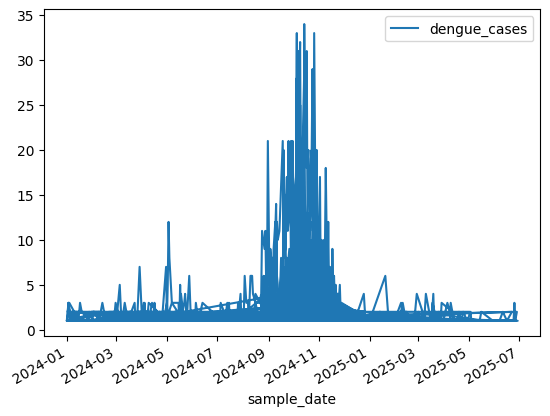

In [ ]:
all_dengue.plot("sample_date")

In [ ]:
all_dengue.to_csv("dengue_malaria/clean/daily_cases_block.csv", index=False)

# District Summary - Dengue

In [ ]:
# Load all sheets
xls = pd.ExcelFile(f"dengue_malaria/raw/dengue_historical_data_copy.xlsx")
sheet_names = xls.sheet_names

# # Read and append all sheets

main_df=pd.DataFrame()

for sheet in sheet_names:
  df = pd.read_excel(f"{data_path}/dengue_historical_data_copy.xlsx", sheet_name=sheet, usecols=['District', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec'])
  df=df.melt(id_vars="District", var_name="Month Name", value_name="Dengue Cases")
  df=df.dropna(subset=["Month Name", "District"], how="any")
  df["Year"]=sheet
  df['month_num'] = pd.to_datetime(df['Month Name'], format='%b').dt.month
  df['Year_Month'] = pd.to_datetime(dict(year=df['Year'], month=df['month_num'], day=1)).dt.to_period('M')
  df.drop(columns=["Month Name", "Year", "month_num"], inplace=True)
  df["District"]=df["District"].str.capitalize().str.strip()
  main_df=pd.concat([main_df, df])


In [ ]:
# change districts to match shape files

# Your mapping dictionary
block_to_district_map = {
    "Chittorgarh": "Chittaurgarh",
    "Dholpur": "Dhaulpur",
    "Jalore": "Jalor",
    "Jhunjhunu": "Jhunjhunun",
    "S. madhopur": "Sawai Madhopur",
    "S.ganganagar": "Ganganagar",
    "Anupgarh": "Ganganagar",
    "Balotra": "Barmer",
    "Beawar": "Ajmer",
    "Deeg": "Bharatpur",
    "Didwana": "Nagaur",
    "Dudu": "Jaipur",
    "Gangapur city": "Sawai Madhopur",
    "Jaipur rural": "Jaipur",
    "Jodhpur rural": "Jodhpur",
    "Kekri": "Ajmer",
    "Khairthal": "Alwar",
    "Kotputli": "Jaipur",
    "Neem ka thana": "Sikar",
    "Phalodi": "Jodhpur",
    "Salumber": "Udaipur",
    "Sanchore": "Jalor",
    "Shahpura": "Bhilwara"
}

# Replace values in 'dtname' where key exists, otherwise keep the original
main_df['New_District'] = main_df['District'].replace(block_to_district_map)


In [ ]:
hist_dist=main_df.copy()

In [ ]:
dengue_2025=pd.read_csv("dengue_malaria/clean/daily_cases_block.csv")

In [ ]:
dengue_2025["sample_date"]=pd.to_datetime(dengue_2025["sample_date"])

In [ ]:
dengue_2025=dengue_2025[dengue_2025["sample_date"]>=pd.to_datetime("2025-01-01")]

In [ ]:
dengue_2025["Year_Month"]=dengue_2025["sample_date"].dt.to_period('M')

In [ ]:
dengue_2025_dist=dengue_2025.groupby(by=["dtname", "Year_Month"])["dengue_cases"].sum().reset_index()

In [ ]:
hist_dist=hist_dist.groupby(by=["New_District", "Year_Month"])["Dengue Cases"].sum().reset_index().rename(columns={
    "New_District":"dtname",
    "Dengue Cases":"dengue_cases"
})

In [ ]:
hist_dist["Year_Month"].min(), hist_dist["Year_Month"].max()

('2019-01', '2024-12')

In [ ]:
dengue_2025_dist["Year_Month"].min(), dengue_2025_dist["Year_Month"].max()

(Period('2025-01', 'M'), Period('2025-06', 'M'))

In [ ]:
dengue_2025_dist["Year_Month"]=dengue_2025_dist["Year_Month"].astype(str)
hist_dist["Year_Month"]=hist_dist["Year_Month"].astype(str)

In [ ]:
all_dist=pd.concat([hist_dist, dengue_2025_dist])

In [ ]:
all_dist.duplicated(subset=["dtname", "Year_Month"]).sum()

np.int64(0)

In [ ]:
all_dist.to_csv("dengue_malaria/clean/dengue_dist_summary.csv", index=False)

#Climate - Create 10km x 10km grid

Extract & Aggregate Climate Data - ERA5 - Block-level - Don't run

In [ ]:
# 1. Project to metric CRS (UTM or EPSG:32643 for Rajasthan)
boundary = blocks_shp.to_crs(epsg=32643)  # UTM zone 43N (meters)

# 2. Create 10 km spaced grid (10,000 meters)
minx, miny, maxx, maxy = boundary.total_bounds
x_coords = np.arange(minx, maxx, 10000)
y_coords = np.arange(miny, maxy, 10000)

# 3. Create mesh of points
points = [Point(x, y) for x in x_coords for y in y_coords]
grid = gpd.GeoDataFrame(geometry=points, crs=boundary.crs)

# 4. Clip points to the boundary (optional but recommended)
grid_clipped = gpd.sjoin(grid, boundary, predicate="within", how="inner")

# 5. Reproject back to WGS84 (lat/lon) if you need for API extraction
grid_clipped = grid_clipped.to_crs(epsg=4326)

# Optional: Export
grid_clipped.to_file("RAJASTHAN/rajasthan_10km_grid.geojson", driver="GeoJSON")


# Climate - Extract API data for grid points - Run for every extraction

In [ ]:
grid_clipped=gpd.read_file("RAJASTHAN/rajasthan_10km_grid.geojson")

In [ ]:
grid_clipped["NAME"].nunique()

238

In [ ]:
grid_clipped.columns

Index(['index_right', 'NAME', 'DISTRICT', 'C_CODE11', 'geometry'], dtype='object')

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm

start_date = "2024-01-01"
end_date = "2025-09-30"

base_url = "https://archive-api.open-meteo.com/v1/era5"

# Convert list fields to comma-separated strings as required by API
params = {

    "daily": [
      "temperature_2m_max", "temperature_2m_min",
     "relative_humidity_2m_mean", "precipitation_sum"
    ],
    "timezone": "Asia/Kolkata",
    "start_date": start_date,
    "end_date": end_date,
    "apikey": "FrBHTVq25VDS9Lfu"
}

all_data = []
session = requests.Session()  # Reuse TCP connection

for idx, row in tqdm(grid_clipped.iterrows(), total=len(grid_clipped)):
    lat, lon = row.geometry.y, row.geometry.x

    try:
        response = session.get(base_url, params={**params, "latitude": lat, "longitude": lon}, timeout=10)
        response.raise_for_status()  # Raise exception for HTTP errors

        data = response.json()
        daily = data.get("daily")

        if daily:
            daily_df = pd.DataFrame(daily)
            daily_df["latitude"] = lat
            daily_df["longitude"] = lon
            daily_df["point_id"] = idx
            daily_df["DISTRICT"] = row["DISTRICT"]
            daily_df["NAME"] = row["NAME"]
            all_data.append(daily_df)
        else:
            print(f"No daily data for point {idx} ({lat}, {lon})")

    except Exception as e:
        print(f"Request failed for point {idx} ({lat}, {lon}): {e}")

session.close()

# Combine all data
if all_data:
    weather_df = pd.concat(all_data, ignore_index=True)
else:
    weather_df = pd.DataFrame()


100%|██████████| 3420/3420 [13:01<00:00,  4.37it/s]


In [ ]:
weather_df.to_csv("climate_data/openmeteo_era5_grid_data_10kmx10km_2024-01-01_to_2025-09-30.csv", index=False)

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Summer (Mar-May)'
    elif month in [6, 7, 8]:
        return 'Monsoon (Jun-Aug)'
    elif month in [9, 10, 11]:
        return 'Post-Monsoon (Sep-Nov)'
    else:
        return 'Winter (Dec-Feb)'

In [ ]:
all_weather.drop(columns=["month_num"], inplace=True)

In [ ]:
all_weather['season'] = all_weather["time"].dt.month.apply(get_season)

In [ ]:
all_weather["diurnal_temperature_range"]=all_weather["temperature_2m_max"]-all_weather["temperature_2m_min"]

In [ ]:
all_weather.to_csv("climate_data/openmeteo_era5_grid_data_10kmx10km_2019-01-01_to_2025-06-29.csv", index=False)

# Climate - Aggregate API data (at grid-level) to block & day

In [ ]:
all_weather=pd.read_csv("climate_data/openmeteo_era5_grid_data_10kmx10km_2019-01-01_to_2025-06-29.csv")

In [ ]:
all_weather["time"]=pd.to_datetime(all_weather["time"])

In [ ]:
group_cols = ["dtname", "sdtname", "time"]

# Compute mean values per block and date
block_daily_climate = all_weather.groupby(group_cols).agg(
    {"temperature_2m_mean":"mean",
     "temperature_2m_max":"mean",
     "temperature_2m_min":"mean",
     "relative_humidity_2m_mean":"mean",
     "rain_sum":"sum",
     "diurnal_temperature_range":"mean"}
).reset_index()

In [ ]:
block_daily_climate.columns

Index(['dtname', 'sdtname', 'time', 'temperature_2m_mean',
       'temperature_2m_max', 'temperature_2m_min', 'relative_humidity_2m_mean',
       'rain_sum', 'diurnal_temperature_range'],
      dtype='object')

In [ ]:
block_daily_climate["time"].min(), block_daily_climate["time"].max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2025-06-29 00:00:00'))

In [ ]:
block_daily_climate["season"]=block_daily_climate["time"].dt.month.apply(get_season)

In [ ]:
block_daily_climate["season"].value_counts(normalize=True)

,proportion
season,
Summer,0.271501
Winter,0.253373
Monsoon,0.244941
Post-Monsoon,0.230185


In [ ]:
block_daily_climate.to_csv("dengue_malaria/clean/daily_climate_block.csv", index=False)

# Climate - Aggregate API data (at grid-level) to district & day

In [ ]:
all_weather=pd.read_csv("climate_data/openmeteo_era5_grid_data_10kmx10km_2019-01-01_to_2025-06-29.csv")

In [ ]:
all_weather["time"]=pd.to_datetime(all_weather["time"])

In [ ]:
agg_district = (
    all_weather.groupby(['dtname', 'time'])
    .agg({
        'temperature_2m_mean': 'mean',
        'relative_humidity_2m_mean': 'mean',
        'temperature_2m_max': 'mean',
        'temperature_2m_min': 'mean',
        'rain_sum': 'sum',
        'diurnal_temperature_range': 'mean'
    })
    .reset_index()
)


In [ ]:
agg_district["time"].min(), agg_district["time"].max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2025-06-29 00:00:00'))

In [ ]:
agg_district["season"]=agg_district["time"].dt.month.apply(get_season)

In [ ]:
agg_district["season"].value_counts(normalize=True)

,proportion
season,
Summer,0.271501
Winter,0.253373
Monsoon,0.244941
Post-Monsoon,0.230185


In [ ]:
agg_district.columns

Index(['dtname', 'time', 'temperature_2m_mean', 'relative_humidity_2m_mean',
       'temperature_2m_max', 'temperature_2m_min', 'rain_sum',
       'diurnal_temperature_range', 'season'],
      dtype='object')

In [ ]:
agg_district.to_csv("dengue_malaria/clean/daily_climate_district.csv", index=False)

In [ ]:
# The End!